<a href="https://colab.research.google.com/github/Alernst/6D_DLS_Beating_Heart/blob/master/CoLab_CryoInjuryAnalysis_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet-based Segmentation Of Cryo Injuries in AFOG-stained Zebrafish Heart Sections 

---


---




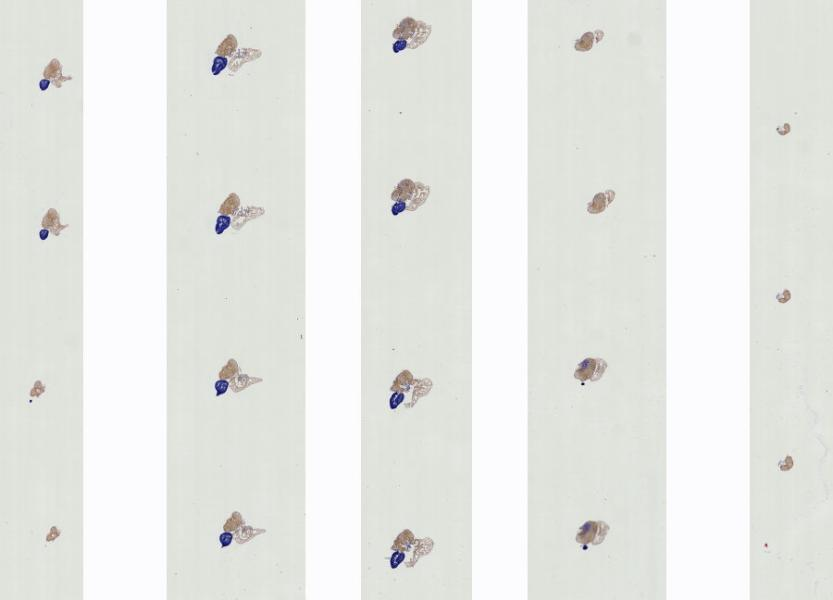

---
---

# **1. Setup: Here all required packages are installed**


---



---


In [24]:

#@title ---> "EXECUTE THIS CELL" to setup the packages and load the functions
#@markdown ---

## Try to import specific packages and install if not found
# %%capture
"""try:
  %tensorflow_version 2.4.1
  import tensorflow
  print(tensorflow.__version__)
  """
#!pip install tensorflow==2.4.1;
from time import process_time
try:
  import openslide
except: 
  !apt update && apt install -y openslide-tools;
  !pip install openslide-python;
  import openslide

try:  
  import slideio

except:  
  !pip install slideio
  import slideio

try:
  import cv2
except:
  !pip install python-opencv
  import cv2

try:
  import tensorflow
except:
  !pip install tensorflow #==2.4.1;
  import tensorflow
  
 
## Basics
import os
import numpy as np
import pandas as pd
from IPython.display import display

## Image processing
import openslide
import skimage
from skimage import io
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.filters import gaussian
import skimage.morphology as skm
from PIL import Image


## Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
 
## Deep Learning

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K

## Statistics
from scipy import stats

## Notebook interactivity
import ipywidgets as widgets
from IPython.display import display
import time
from ipywidgets import interact, IntSlider
## Self defined functions

## Loss function for multilabel/multiclass semantic segmentation
def multi_dice_coef(y_true, y_pred, smooth=1):
    
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)


## Predict function to use the pretrained model for image segmentation

## Default parameters match with the pretrained model
def model_predictions(MODEL,path_images,path_out=None,crop=4096,final_size=512):
    
### If path_save is not default *False*, check whether path exists and create if not 
    if path_out != None:
              if not os.path.exists(path_out+"/Images_Downscaled/") and not os.path.exists(path_save+"/Predictions/"):
                os.mkdir(path_out+"/Images_Downscaled/")
                os.mkdir(path_out+"/Predictions/")
### Get a list of all files in the directory            
    listImages=os.listdir(path_images)
    n_samples=len(listImages)
### Create arrays for output, X <-- images, y <-- segmentations
    X = np.zeros((n_samples, final_size, final_size,3), dtype=np.float32)
    y = np.zeros((n_samples, final_size, final_size,3), dtype=np.float32)  
    

### Start a for loop to apply the model prediction to all images in the folder
    count=0
    for count,i in enumerate(listImages):

#### Default file format is Tiff, change if you chose a different format        
        print(i)
        if ".tif" in i:
            img_arr=np.zeros((1, final_size, final_size,3), dtype=np.float32)

#### Read input images            
            img=io.imread(path_images+"/"+i)

#### Crop images to default 4096,4096 if not already the case, crop happens from the upper left corner             
            image=img[:crop,:crop,:]

#### Resize to default 512,512
            image_downscaled=skimage.transform.resize(image, (final_size, final_size,3),anti_aliasing=False).astype(np.float32)
            img_arr[0,:,:,:]=image_downscaled

#### Apply model for image segmentation
            preds_unseen = MODEL.predict(img_arr, verbose=1)
            
#### Save the images and masks            
            if path_out:
              if not os.path.exists(path_save+"/Images_Downscaled/"):
                io.imsave(path_out+"/Images_Downscaled/Image_"+i,image_downscaled)
                io.imsave(path_out+"/Predictions/UNetSeg_"+i,preds_unseen)
#### Collect segmentations in an array              
            X[count,:,:,:]=image_downscaled
            y[count,:,:,:]=preds_unseen[0,:,:,:]
    return X,y,listImages

def get_area_CiVe(y,thresh_CI,thresh_Ve,listImages):
    results=[]
    for i,name in enumerate(listImages):
          if ".tif" in name:
            area_CI=np.count_nonzero(y[i,:,:,0]>threshold_CI)
            area_Ve=np.count_nonzero(y[i,:,:,1]>threshold_Ve)
            if area_Ve==0:
              ratio=0
            else:  
              ratio=area_CI/area_Ve
            results.append(np.array([name,area_CI,area_Ve,ratio],dtype=object))
    df_results=pd.DataFrame(results,columns=["Filename","Cryo Injury Area [Pixels]","Ventricle Area [Pixels]","Ratio CI/Ve"])
### Return the results as dataframe for further analysis            
    return df_results

### function to visualize images in with the interactive tool
def show_img_seg(image_num):
  
  plt.figure(figsize=(18,6))
  
  plt.subplot(131)
  io.imshow(images_CiVe[image_num,:,:,:])
  ci_mask=predictions[image_num,:,:,0]>threshold_CI
  ci_contours=skimage.measure.find_contours(ci_mask,0)
  for contour in ci_contours:
      plt.plot(contour[:, 1], contour[:, 0], linewidth=1,color='yellow',alpha=1)

  plt.subplot(132)
  io.imshow((predictions[image_num,:,:,1]>threshold_Ve)) #skm.convex_hull_image
  
  plt.subplot(133)
  io.imshow(ci_mask) 
  print(df_results.iloc[image_num])



## This function opens and split ndpi images
def ndpi_test(path_image,save=None,show=True):  
### OpenSlide as package to access multeiple resolution levels of ndpi
    myslide = openslide.OpenSlide(path_image)
   
### Read low resolution using openslide
    level_6=myslide.level_dimensions[6]
    image = myslide.read_region(location=(0,0),level=6,size=level_6)

### Convert to numpy array, select only 2nd channel, apply gaussian, apply threshold
    pix = np.array(image)[:,:,2]
    image_gaussian = gaussian(pix, 10)
    image_thresholded= image_gaussian < 0.830

### Show the images
    if show:
      fig1,ax1=plt.subplots(2,2,figsize=(15, 5))
      ax1[0,0].imshow(image)
      ax1[0,1].imshow(pix,cmap="gray")
      ax1[1,0].imshow(image_gaussian,cmap="gray")
      ax1[1,1].imshow(image_thresholded,cmap="gray")
      plt.tight_layout()
      plt.show()

### Detect heart sections, using skimage blob detection, difference of hessian
    blobs_doh = blob_doh(image_thresholded, max_sigma=40, threshold=.05)
    blobs_list = [blobs_doh]
    colors = ['red']
    titles = ['Determinant of Hessian']

### Join the detected blots with the box color and a title
    sequence = zip(blobs_list, colors, titles)
    if show:
      fig2,ax2=plt.subplots(1,figsize=(15, 5))
      ax2.imshow(image)

### Show the detected sections on the whole slide
    for idx,(blobs, color, title) in enumerate(sequence):
        for blob in blobs:
            y, x, r = blob
            c = mpatches.Rectangle((x-r*1.0, y-r*1.0), 4096/64,4096/64, color=color, linewidth=2, fill=False)
            if show:
              ax2.add_patch(c)
    if show:
      plt.tight_layout()
      plt.show()

### Sort the sections on the slide by location   
    df=pd.DataFrame(blobs).sort_values(by=[1,2],ascending=True).reset_index().drop(columns='index')
### Create an array to collect results
    n_samples=len(df)
    detected_sections = np.zeros((n_samples, 512, 512,3), dtype=np.float32)

### Save the sections to tif files, by looping through the sorted dataframe
    count=0
    name_list=[]
    for index, blob1 in df.iterrows():
              t0_start=process_time()
              blob2=blob1.to_numpy()
              y1, x1, r = blob2
              t0_stop=process_time()
### Read cropped fill resolution images, generate a filename, convert channels
              t1_start=process_time()
              image_ht_full=myslide.read_region(location=(64*(int(round(x1-1.1*r))),64*(int(round(y1-1.1*r)))),level=0,size=(4096,4096))
              t1_stop=process_time()
              y_um= str(round(float(myslide.properties['openslide.mpp-y'])*(4096/512),3)).replace(".","-")
              pix_fl = np.array(image_ht_full) 
              name=(path_image.rsplit("/",1)[1].replace(".ndpi","_") +"_pxsize"+ y_um +"um_"+ str(count) + ".tif")
              
              t2_start=process_time()
              im=Image.fromarray(pix_fl, 'RGBA')
              im2=np.array(im.convert("RGB")) /255
              
### Create an array to collect the images
              
              detected_sections[count,:,:,:] = skimage.transform.resize(im2, (512, 512,3),anti_aliasing=False).astype(np.float32)
              name_list.append(name)
              t2_stop=process_time()
### Finally save the images
              print(count,"0:{}s, 1:{}s,2:{}s".format(t0_stop-t0_start,t1_stop-t1_start,t2_stop-t2_start))
              count+=1
       
    if save:
       for image in range(detected_sections.shape[0]):
          im_out= detected_sections[image,:,:,:]
          path_save_test=os.path.join(save,name_list[image])
          print(path_save_test)
          io.imsave(path_save_test,im_out, metadata={'YResolution': y_um,'XResolution':y_um}) 
    
    print(name)
    
    
    return (df, detected_sections)

#ToDo improve processing of czi multiscene files
def czi_test(file,folderpath,output,out_size=512,full_size=8192):
### Get file path    
    filepath = os.path.join(folderpath,file)


### Use slideio to access czi multiscene files, OpenSlide doesnt work
    slide = slideio.open_slide(filepath, "CZI")
### Get number of scene    
    N = slide.num_scenes
    counter = 0
### Create an array to collect resulting images
    detected_sections = np.zeros((N, size, size,3), dtype=np.float32)
    
    for i in range(N):
### Get the scenes and their properties
        scene = slide.get_scene(i)
        width=scene.rect[2]
        height=scene.rect[3]
        props=scene.resolution[0]
        print(width,height,props)
### Load only a 64 times downsampled image and convert to array
        block = scene.read_block(size=(round(width/64),round(height/64)))
        image = cv2.cvtColor(block, cv2.COLOR_BGR2RGB)
        image_gray = np.array(image)[:,:,0]
### Perform filtering, thresholding and blob detection, because not all scenes contain only one section
        image_thresholded=(gaussian(image_gray, 15) < 0.9)
        blobs_doh = [blob_doh(image_thresholded, max_sigma=50, threshold=.05)]
### Create a dataframe and loop through the detected blobs        
        df=pd.DataFrame(blobs).reset_index().drop(columns='index')

        for index, blob1 in df.iterrows():
                blob2=blob1.to_numpy()
                y1, x1, r = blob2
### Calculate the coordinates of each blob from the downscaled image
                rect_coord=(64*(int(round(x1-1.5*r))),64*(int(round(y1-1.5*r))),full_size,full_size)
### Load each blob with 512x512
                image_ht_full=scene.read_block(rect_coord,(out_size,out_size))
                pix_fl = np.array(image_ht_full) 
### Generate a filename and path for saving
                splitpath=filepath.split("/")[-1]
                name=os.path.join(output, splitpath.replace(".czi","_") + str(counter) + ".tif")
### Convert to the right colorspace and save the images               
                im= cv2.cvtColor(pix_fl, cv2.COLOR_BGR2RGB)
                im2=Image.fromarray(im, 'RGB')
                pix_scaling=full_size/out_size
                im2.save(name,resolution=(pix_scaling*(1/props*0.01),pix_scaling*(1/props*0.01)),resolution_unit=3, metadata={'Pixel width':pix_scaling*(1/props*0.01),'Pixel height':pix_scaling*(1/props*0.01),'ResolutionUnit': 'micron'})
                print(name,"_saved")
### Store the reuslts in an array
                detected_sections[counter,:,:,:]=(np.array(im2)/255).astype(np.float32)
                counter+=1
### Show the first image as example                
    io.imshow((detected_sections[0,:,:,:]))
    return (df, detected_sections)

In [7]:
#@title ---> "EXECUTE THIS CELL" to mount your Google Drive

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Background information: Enter the required information**


---



---


In [ ]:

#@markdown Enter folder path with images
path_images = "/content/Data" #@param {type:"string"}
input_format="ndpi" #@param {type:"string"}
"""
 @markdown Enter folder path to save results (optional)
#Enter output paths
path_save=None @param {type:"string"}
"""
#@markdown Enter output format "tif", currently only ".tif" supported

output_format="tif" #@param["tif"] {type:"string"}
#ToDo add additional output formats {, "jpg", "png"}

#@markdown Enter the type of sample
Type = "Whole_Slides_Multi_Section" #@param ["Whole_Slides_Multi_Section", "Single_Sections"] {type:"raw"}


# Create list and DataFrame for visualization 
slides=os.listdir(path_images)
files=pd.DataFrame(slides,columns=["Filename"])
files["Image_formats"]=files["Filename"].str.rsplit(".",n=1,expand=True)[1]

suffix_list=files["Image_formats"].unique()

print(files)
if len(suffix_list)>1:
  count_images=files["Image_formats"].value_counts()
  suffix=count_images.idxmax(axis = 0)
  
  print("\n\033[1m" +"Warning: Images have multiple formats, only the most frequent format will be processed now.\n The most frequent is format: {}".format(suffix)+ "\033[0m")
else:
  suffix=suffix_list[0]



if (input_format not in ["ndpi","czi","tif"]) or (suffix not in ["ndpi","czi","tif"]): 
  proceed=False
  print("\n\033[1m" +"ERROR: The image format {} or {} is not currently supported. Try conversion to tif.".format(input_format,suffix)+ "\033[0m")
elif input_format != suffix:
  proceed=False
  print("\n\033[1m" +"Warning: The images that will be processed are {} and not {}".format(suffix,input_format)+ "\033[0m")

elif input_format == suffix and (len(suffix_list) != 1):
  proceed=True
  print("You can proceed, but only the {} will be processed.".format(suffix))

elif (input_format == suffix) and (len(suffix_list) == 1):
  proceed=True
  print("All good so far!\n Proceed!")

# **3. Processing: Prepare your images**


---



---


In [8]:

#@title Run this cell to verify your input.
#@markdown Optional: Enter a path for saving the test images eg. "./Test_Results" .
path_save = "Create automatically" #@param ["Create automatically", "Type here"] {allow-input: true}

save_results = True #@param {type:"boolean"}
save_all_slides = True #@param {type:"boolean"}
path_slide1=slides[0]
path_exists=os.path.exists(os.path.join(path_images, path_slide1))
if path_exists:
  path_image1=os.path.join(path_images, path_slide1)
  
  print("The path exists:   {}".format(path_image1))
  if ((save_results) or suffix != "tif") and (not save_all_slides):
    if path_save == "Create automatically":
      if not os.path.exists("./Test_Results"):
        os.mkdir("./Test_Results")
      path_save="./Test_Results"
      
      if suffix=="ndpi":
        df_slides,img=ndpi_test(path_image1,path_save)
      elif suffix == "czi":
        df_slides,img=czi_test(path_slide1,path_images,path_save)
    else:
      if suffix=="ndpi":
        df_slides,img=ndpi_test(path_image1,path_save)
  if save_all_slides:
    if path_save == "Create automatically":
      if not os.path.exists("./Test_Results"):
        os.mkdir("./Test_Results")
      path_save="./Test_Results"

    all_slides=[ndpi_test(os.path.join(path_images, slide_i),path_save,show=False) for slide_i in slides]
    print("If path is on virtual machine eg. './Test_Results', you can download the images from there (see explorer on the left).")
  else:
    if suffix=="czi":
      df_slides,img=ndpi_test(path_image1)
    elif suffix=="czi":
      df_slides,img=czi_test(path_image1)
    elif suffix=="tif":
      print("No export is necessary")
elif not proceed:
  print("Something is wrong in the previous cell. Maybe your file format does not match the requirements.")

else:
  proceed=False
  print("There is something wrong with the file paths!")





The path exists:   /content/Data/64 - 2020-12-17 16.24.07.ndpi
0 0:4.6964000006255446e-05s, 1:0.3351064890000117s,2:0.5301674929999933s
1 0:3.25999999972737e-05s, 1:0.31139656099999513s,2:0.6415715569999918s
2 0:3.2461000003536356e-05s, 1:0.31969360099999733s,2:0.5509881189999959s
3 0:3.275500000654574e-05s, 1:0.3226021159999988s,2:0.5468346359999998s
4 0:3.2013000009101233e-05s, 1:0.3314112449999982s,2:0.5359056599999974s
5 0:2.9777999998259475e-05s, 1:0.32242901900001186s,2:0.5325610420000118s
6 0:3.165500000079646e-05s, 1:0.33347617199999036s,2:0.5281060740000072s
7 0:3.110800000172276e-05s, 1:0.3379831690000117s,2:0.546600440000006s
8 0:3.28479999893716e-05s, 1:0.3287246089999911s,2:0.565767876999999s
9 0:3.1212999999752356e-05s, 1:0.3261577059999894s,2:0.5389244320000017s
10 0:3.426700000375149e-05s, 1:0.34223533300000497s,2:0.5417973780000125s
11 0:2.9197000003478024e-05s, 1:0.33351916499999845s,2:0.5327590490000063s
12 0:3.3670999997070794e-05s, 1:0.32243591099999946s,2:0.538064

# **4. Analysis: Here starts the Unet segmentation part**


---



---





In [9]:
#path_model="/content/drive/MyDrive/CI_segmentation/Models/weights_best___mult_rescaleintensity2.hdf5"
#@markdown Execute to load the model, multiple models will be available here in the future
path_model = "/content/drive/MyDrive/CI_segmentation/Models/weights_best___mult_rescaleintensity2.hdf5" #@param {type:"string"}

model = load_model(path_model, custom_objects={'multi_dice_coef': multi_dice_coef})



In [25]:
images_to_segment = "Default" #@param {type:"string"}
path_output = "./Test_Segmentation/" #@param {type:"string"}
threshold_Ve = 0.6 #@param {type:""}
threshold_CI = 0.8 #@param {type:""}
save_output = True #@param {type:"boolean"}
show_output_image_1 = False #@param {type:"boolean"}
show_measurements = True #@param {type:"boolean"}




if images_to_segment == "Default":
  path_save="./Test_Results/"

if (save_output == True) and (path_output == "./Test_Segmentation/"):
  if not os.path.exists("./Test_Segmentation/"):
    os.mkdir("./Test_Segmentation/")
elif not save_output:
  path_output= None

if len(os.listdir(path_save)) != 0:
  images_CiVe,predictions,listImg=model_predictions(model,path_save,path_out=path_output)
  df_results=get_area_CiVe(predictions,threshold_CI,threshold_Ve,listImg)
    
  if show_output_image_1:
    image_num=0
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    io.imshow(images_CiVe[image_num,:,:,:])
    plt.subplot(132)
    io.imshow((predictions[image_num,:,:,1]>threshold_Ve)) #skm.convex_hull_image
    plt.subplot(133)
    io.imshow((predictions[image_num,:,:,0]>threshold_CI)) #skm.convex_hull_image(
  if show_measurements:
    display(df_results)
else:
  print("The directory {} is empty.".format(path_save))      

64 - 2020-12-17 16.24.07__pxsize3-622um_10.tif
1/1 [==============================] - 1s 785ms/step
66 - 2020-12-17 16.34.23__pxsize3-622um_6.tif
1/1 [==============================] - 1s 757ms/step
65 - 2020-12-17 16.29.32__pxsize3-622um_1.tif
1/1 [==============================] - 1s 754ms/step
65 - 2020-12-17 16.29.32__pxsize3-622um_2.tif
1/1 [==============================] - 1s 750ms/step
66 - 2020-12-17 16.34.23__pxsize3-622um_4.tif
1/1 [==============================] - 1s 746ms/step
64 - 2020-12-17 16.24.07__pxsize3-622um_1.tif
1/1 [==============================] - 1s 729ms/step
66 - 2020-12-17 16.34.23__pxsize3-622um_11.tif
1/1 [==============================] - 1s 739ms/step
66 - 2020-12-17 16.34.23__pxsize3-622um_9.tif
1/1 [==============================] - 1s 747ms/step
66 - 2020-12-17 16.34.23__pxsize3-622um_1.tif
1/1 [==============================] - 1s 764ms/step
64 - 2020-12-17 16.24.07__pxsize3-622um_6.tif
1/1 [==============================] - 1s 767ms/step
66 - 202

,Filename,Cryo Injury Area [Pixels],Ventricle Area [Pixels],Ratio CI/Ve
0,64 - 2020-12-17 16.24.07__pxsize3-622um_10.tif,443,16796,0.026375
1,66 - 2020-12-17 16.34.23__pxsize3-622um_6.tif,0,21846,0.000000
2,65 - 2020-12-17 16.29.32__pxsize3-622um_1.tif,0,15691,0.000000
3,65 - 2020-12-17 16.29.32__pxsize3-622um_2.tif,0,30859,0.000000
4,66 - 2020-12-17 16.34.23__pxsize3-622um_4.tif,0,22124,0.000000
5,64 - 2020-12-17 16.24.07__pxsize3-622um_1.tif,0,9120,0.000000
6,66 - 2020-12-17 16.34.23__pxsize3-622um_11.tif,2482,17635,0.140743
7,66 - 2020-12-17 16.34.23__pxsize3-622um_9.tif,847,24173,0.035039
8,66 - 2020-12-17 16.34.23__pxsize3-622um_1.tif,3,10486,0.000286
9,64 - 2020-12-17 16.24.07__pxsize3-622um_6.tif,1256,23671,0.053061


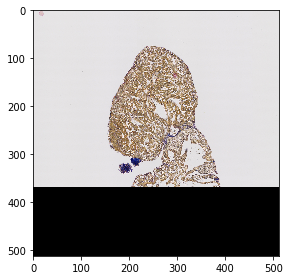

In [26]:
io.imshow(images_CiVe[1],vmax=1)

In [27]:
#@markdown Execute to get interactive viewer

interact(show_img_seg, image_num = IntSlider(min=0,max=predictions.shape[0],step=1,value=0,continuous_update = True));

interactive(children=(IntSlider(value=0, description='image_num', max=38), Output()), _dom_classes=('widget-in…

# Load a table with image names/ image groups


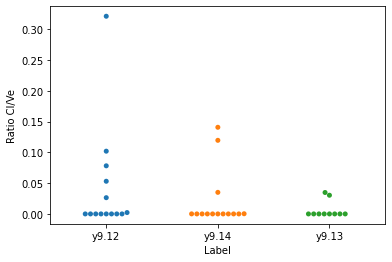

In [28]:
#@markdown Execute to load the model, multiple models will be available here in the future
path_labels = "/content/drive/MyDrive/CI_segmentation/Data/Tables/Labels_Slides_test.xlsx" #@param {type:"string"}

def labeler(string,dict_labels,label_name):
  name=str(string).split("__")[0]
  label=dict_labels.get(name)[label_name]
  return label

df_labels=pd.read_excel(path_labels)
df_labels["Individual"]=df_labels["Label"].str.split(" ",expand=True)[3]
df_labels_T=df_labels.T
df_labels_T.columns=df_labels.Filename
dict_labels=df_labels_T.to_dict()

df_results["Label"]=df_results["Filename"].apply(labeler,dict_labels=dict_labels,label_name="Individual")

sns.swarmplot(x="Label",y="Ratio CI/Ve",data=df_results)